In [1]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [2]:
Train_data = pd.read_csv('used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('used_car_testB_20200421.csv', sep=' ')

print('Train data shape:',Train_data.shape)
print('TestB data shape:',Test_data.shape)


Train data shape: (150000, 31)
TestB data shape: (50000, 30)


In [3]:
Test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [4]:
Train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [5]:
Train_data['notRepairedDamage'].value_counts()


0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [6]:
Train_data['notRepairedDamage'].replace('-', np.nan, inplace=True)
Test_data['notRepairedDamage'].replace('-', np.nan, inplace=True)
Train_data['notRepairedDamage'].value_counts()


0.0    111361
1.0     14315
Name: notRepairedDamage, dtype: int64

In [7]:
Train_data.isnull().sum()


SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage    24324
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

<AxesSubplot:>

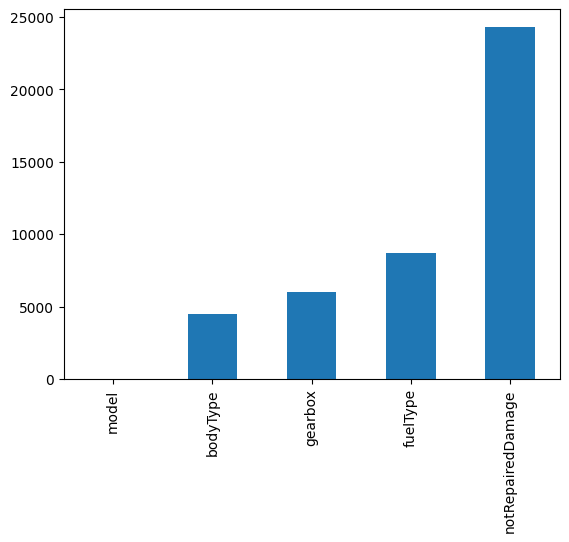

In [8]:
missing = Train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()


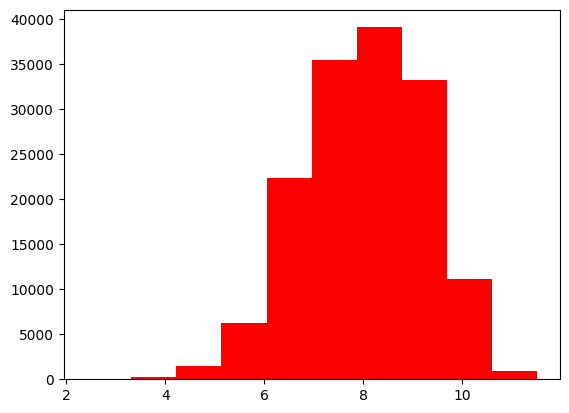

In [9]:

Train_data['price'] = np.log(Train_data['price'])

plt.hist(Train_data['price'], orientation = 'vertical',histtype = 'bar', color ='red')

plt.show()

In [10]:
del Train_data["seller"]
del Train_data["offerType"]
del Test_data["seller"]
del Test_data["offerType"]


In [11]:
Train_data['train']=1
Test_data['train']=0
data = pd.concat([Train_data, Test_data], ignore_index=True)


In [12]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days


In [13]:
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data


In [14]:
Train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')


In [15]:
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()


,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [16]:
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)


<AxesSubplot:ylabel='Frequency'>

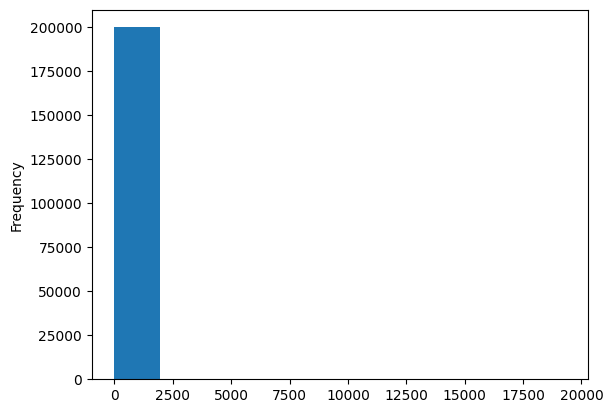

In [17]:
data['power'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

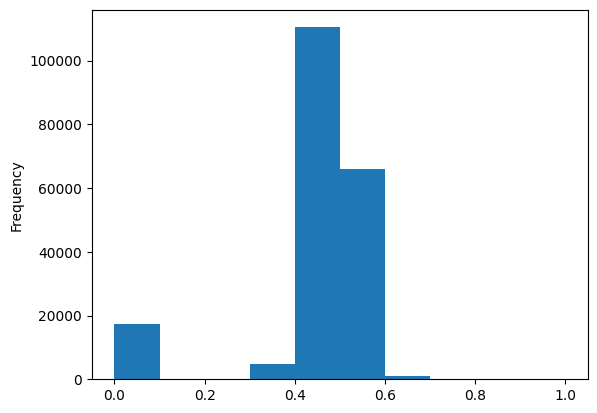

In [18]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

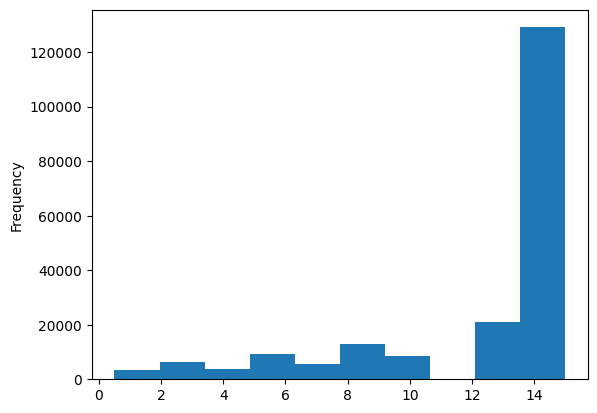

In [19]:
data['kilometer'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

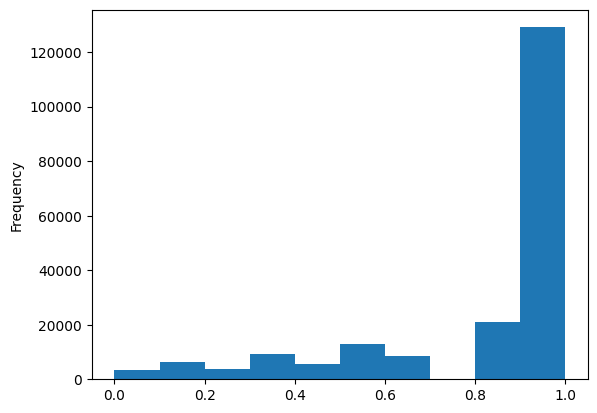

In [20]:
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()


In [21]:
data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))


In [22]:
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14','used_time']
# 我们将每一个变量的均值和方差都存储到scaled_features变量中。
scaled_features = {}
for each in numeric_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std


In [23]:
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin','city'])


In [24]:
import torch
import torch.nn as nn
#from torch.autograd import Variable
import torch.optim as optim


In [25]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        这样可以大幅度减少存储大小，提升效率。
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

sample_feature = reduce_mem_usage(data)
sample_feature.shape
sample_feature = sample_feature.fillna(-1)
sample_feature.shape

# 拆分数据集
X_train = sample_feature[sample_feature['train']==1]
X_test = sample_feature[sample_feature['train']!=1]

# 输出一下
print(X_train.info)
print(X_test.info)

# 提取label
X_train_label = X_train.pop('price')

# 删掉数据集的标签和来源
del X_test['price']
del X_train['train']
del X_test['train']

# 剔除不必要的列
X_train_SaleID = X_train.pop('SaleID')
X_train_name = X_train.pop('name')
X_test_SaleID = X_test.pop('SaleID')
X_test_name = X_test.pop('name')

# 输出一下
print(X_train.info)
print(X_test.info)


Memory usage of dataframe is 117200000.00 MB
Memory usage after optimization is: 152200000.00 MB
Decreased by -29.9%
<bound method DataFrame.info of         SaleID    name     power  kilometer     price       v_0       v_1  \
0            0     736 -0.167847  -0.024872  7.523438 -0.425781  1.103516   
1            1    2262 -3.093750   0.613281  8.187500  0.366455  1.452148   
2            2   14874  0.536133  -0.024872  8.734375  0.640137  1.338867   
3            3   71865  0.655762   0.613281  7.785156  0.521973  1.248047   
4            4  111080 -0.080078  -1.939453  8.554688 -0.008621  0.571777   
...        ...     ...       ...        ...       ...       ...       ...   
149995  149995  163978  0.536133   0.613281  8.679688  0.370850 -0.848633   
149996  149996  184535  0.348633  -0.663086  9.156250  0.637695 -0.849609   
149997  149997  147587  0.116943  -1.683594  8.921875  0.133789 -0.839355   
149998  149998   45907  0.505371   0.613281  8.515625  0.510254 -0.866699   
1499

In [26]:
print(type(X_train_label))
print(type(X_train))
print(type(X_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [27]:
print(X_train_label)
print(X_train)
print(X_test)

0         7.523438
1         8.187500
2         8.734375
3         7.785156
4         8.554688
            ...   
149995    8.679688
149996    9.156250
149997    8.921875
149998    8.515625
149999    8.453125
Name: price, Length: 150000, dtype: float16
           power  kilometer       v_0       v_1       v_2       v_3       v_4  \
0      -0.167847  -0.024872 -0.425781  1.103516 -0.010323  1.028320  0.942383   
1      -3.093750   0.613281  0.366455  1.452148  0.019592  0.643066 -1.207031   
2       0.536133  -0.024872  0.640137  1.338867  0.422852 -0.532227 -0.851074   
3       0.655762   0.613281  0.521973  1.248047 -0.044739  0.397461 -1.881836   
4      -0.080078  -1.939453 -0.008621  0.571777  0.167847 -0.814941  1.865234   
...          ...        ...       ...       ...       ...       ...       ...   
149995  0.536133   0.613281  0.370850 -0.848633 -0.460938 -0.402588 -1.277344   
149996  0.348633  -0.663086  0.637695 -0.849609 -0.035492 -1.208008  0.568848   
149997  0.116943  

In [28]:
for x in X_train.columns:
    print(x, "\n")

power 

kilometer 

v_0 

v_1 

v_2 

v_3 

v_4 

v_5 

v_6 

v_7 

v_8 

v_9 

v_10 

v_11 

v_12 

v_13 

v_14 

used_time 

brand_amount 

brand_price_max 

brand_price_median 

brand_price_min 

brand_price_sum 

brand_price_std 

brand_price_average 

model_0.0 

model_1.0 

model_2.0 

model_3.0 

model_4.0 

model_5.0 

model_6.0 

model_7.0 

model_8.0 

model_9.0 

model_10.0 

model_11.0 

model_12.0 

model_13.0 

model_14.0 

model_15.0 

model_16.0 

model_17.0 

model_18.0 

model_19.0 

model_20.0 

model_21.0 

model_22.0 

model_23.0 

model_24.0 

model_25.0 

model_26.0 

model_27.0 

model_28.0 

model_29.0 

model_30.0 

model_31.0 

model_32.0 

model_33.0 

model_34.0 

model_35.0 

model_36.0 

model_37.0 

model_38.0 

model_39.0 

model_40.0 

model_41.0 

model_42.0 

model_43.0 

model_44.0 

model_45.0 

model_46.0 

model_47.0 

model_48.0 

model_49.0 

model_50.0 

model_51.0 

model_52.0 

model_53.0 

model_54.0 

model_55.0 

model_56.0 

model_57.0 


Epoch [10/5000], Loss: 43.1761
Epoch [20/5000], Loss: 36.8466
Epoch [30/5000], Loss: 26.9206
Epoch [40/5000], Loss: 8.1158
Epoch [50/5000], Loss: 3.4541
Epoch [60/5000], Loss: 0.5113
Epoch [70/5000], Loss: 0.6175
Epoch [80/5000], Loss: 0.4088
Epoch [90/5000], Loss: 0.2595
Epoch [100/5000], Loss: 0.2362
Epoch [110/5000], Loss: 0.2166
Epoch [120/5000], Loss: 0.1965
Epoch [130/5000], Loss: 0.1828
Epoch [140/5000], Loss: 0.1727
Epoch [150/5000], Loss: 0.1644
Epoch [160/5000], Loss: 0.1572
Epoch [170/5000], Loss: 0.1509
Epoch [180/5000], Loss: 0.1452
Epoch [190/5000], Loss: 0.1400
Epoch [200/5000], Loss: 0.1352
Epoch [210/5000], Loss: 0.1308
Epoch [220/5000], Loss: 0.1267
Epoch [230/5000], Loss: 0.1228
Epoch [240/5000], Loss: 0.1191
Epoch [250/5000], Loss: 0.1155
Epoch [260/5000], Loss: 0.1122
Epoch [270/5000], Loss: 0.1092
Epoch [280/5000], Loss: 0.1066
Epoch [290/5000], Loss: 0.1041
Epoch [300/5000], Loss: 0.1018
Epoch [310/5000], Loss: 0.0999
Epoch [320/5000], Loss: 0.0983
Epoch [330/500

Epoch [2610/5000], Loss: 0.0488
Epoch [2620/5000], Loss: 0.0484
Epoch [2630/5000], Loss: 0.0483
Epoch [2640/5000], Loss: 0.0482
Epoch [2650/5000], Loss: 0.0486
Epoch [2660/5000], Loss: 0.0481
Epoch [2670/5000], Loss: 0.0480
Epoch [2680/5000], Loss: 0.0480
Epoch [2690/5000], Loss: 0.0479
Epoch [2700/5000], Loss: 0.0480
Epoch [2710/5000], Loss: 0.0479
Epoch [2720/5000], Loss: 0.0477
Epoch [2730/5000], Loss: 0.0480
Epoch [2740/5000], Loss: 0.0476
Epoch [2750/5000], Loss: 0.0477
Epoch [2760/5000], Loss: 0.0475
Epoch [2770/5000], Loss: 0.0474
Epoch [2780/5000], Loss: 0.0479
Epoch [2790/5000], Loss: 0.0472
Epoch [2800/5000], Loss: 0.0474
Epoch [2810/5000], Loss: 0.0472
Epoch [2820/5000], Loss: 0.0474
Epoch [2830/5000], Loss: 0.0470
Epoch [2840/5000], Loss: 0.0470
Epoch [2850/5000], Loss: 0.0475
Epoch [2860/5000], Loss: 0.0469
Epoch [2870/5000], Loss: 0.0468
Epoch [2880/5000], Loss: 0.0468
Epoch [2890/5000], Loss: 0.0470
Epoch [2900/5000], Loss: 0.0466
Epoch [2910/5000], Loss: 0.0468
Epoch [2

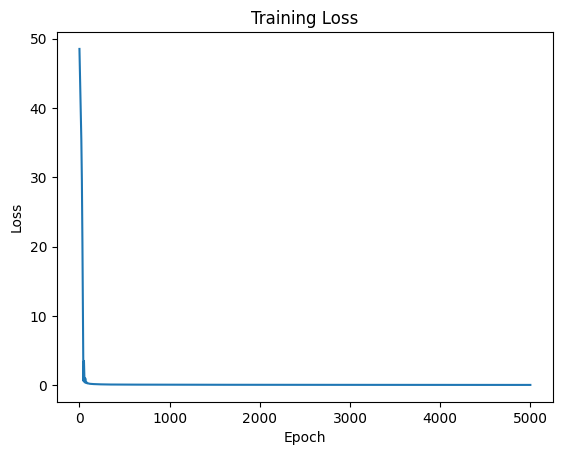

In [44]:
# 自己写的模型

# 搭建模型
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,output_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.LeakyReLU(0.01)
        self.fc4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_dim4, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out) 
        out = self.fc4(out)
        out = self.relu4(out)
        out =self.fc5(out)
        return out
    
# 超参数设定
input_dim = X_train.shape[1]
hidden_dim1 = 100
hidden_dim2 = 50
hidden_dim3 = 25
hidden_dim4 = 15
output_dim = 1
learning_rate = 0.001
num_epochs = 5000


# 初始化模型
model = MyModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, output_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()  # 损失函数是MSELoos，可以换成L1loos，使用：nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# 转化为numpy数组,再转化为torch张量
x_train = torch.tensor(X_train.values, dtype = torch.float32)  # 训练集转化为张量
y_train = torch.tensor(X_train_label.values.reshape(-1, 1), dtype = torch.float32)  # 标签转化为张量

# 方便存储loss
train_losses = []


# 训练模型
for epoch in range(num_epochs):
    # 前向传播
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    train_losses.append(loss.item())  # 记录每次迭代的loss值
    # 反向传播和参数更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    # 输出结果
    if(epoch +1)% 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


# 可视化训练过程中的loss值
plt.plot(range(num_epochs), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [45]:
# 测试模型

x_test = torch.tensor(X_test.values, dtype=torch.float32)
y_pred = pd.DataFrame(np.exp(model(x_test).detach().numpy()))

y_test_id = pd.read_csv('./used_car_sample_submit.csv')
result = pd.concat([y_test_id['SaleID'], y_pred], axis=1)
result.columns = ['SaleID','price']
result.to_csv('./result9.csv', index=False)
